<a href="https://colab.research.google.com/github/SJP0308/MLTUTORIAL/blob/House-Prices/House_Prices2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **문제 정의**

**It is your job to predict the sales price for each house.** For each Id in the test set, you must predict the value of the SalePrice variable.

# **평가 방식**

**Submissions are evaluated on Root-Mean-Squared-Error (RMSE)** between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

# **Download**

In [1]:
# 데이터셋 다운로드
def download_dataset(datafile_name):
  from google.colab import drive
  drive.mount('/content/drive')
  path = f'/content/drive/My Drive/{datafile_name}'
  train_df = pd.read_csv(f'{path}/train.csv')
  test_df = pd.read_csv(f'{path}/test.csv')
  print('데이터 다운로드 완료!')
  return pd.concat([train_df, test_df], ignore_index=True)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
# 경고 메시지를 무시하도록 설정
warnings.filterwarnings('ignore')

# 플롯을 인라인으로 표시하도록 설정
%matplotlib inline

df = download_dataset('house_prices')

Mounted at /content/drive
데이터 다운로드 완료!


# **Data processing**

In [3]:
# 스피어맨 인코딩
def Spearman_encode(df, feature):
    ordering = df.groupby(feature)['SalePrice'].mean().sort_values().reset_index()
    ordering['ordering'] = range(1, len(ordering)+1)
    df[feature] = df[feature].map(dict(zip(ordering[feature], ordering['ordering'])))
    return df

In [4]:
quantitative = df.select_dtypes(include='number').drop(columns=['Id', 'SalePrice'])
qualitative = df.select_dtypes(include='object')

for col in qualitative:
  df = Spearman_encode(df, col)

In [5]:
df = df.drop(df[(df['GrLivArea']>4000) & (df['SalePrice']<2.60)].index)
df.reset_index(drop=True, inplace=True)
df['SalePrice'] = np.log1p(df.SalePrice)

# **Features**

In [6]:
# groupby로 결측치 채우기
def fill_null_by_group(df, group_col, target_col):
  return df[target_col].fillna(df.groupby(group_col)[target_col].transform(lambda x: x.mode()[0] if not x.mode().empty
                                                                           else df[target_col].mode()[0]))

In [7]:
for col in ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu',
            'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']:
            df[col] = df[col].fillna('None')

for col in ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']:
  df[col] = df[col].fillna(0)

groupby = {'Neighborhood': ['MSZoning', 'LotFrontage', 'Exterior1st', 'Exterior2nd', 'Electrical'],
           'KitchenAbvGr': ['KitchenQual'],
           'GarageType': ['GarageYrBlt', 'GarageCars', 'GarageArea']}
for key, group in groupby.items():
  for col in group:
    df[col] = fill_null_by_group(df, key, col)

df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])
df["Functional"] = df["Functional"].fillna("Typ")
df.drop(['Id'], axis=1, inplace=True)
df.drop(['Utilities'], axis=1, inplace=True)

for col in ['MSSubClass', 'YrSold', 'MoSold']:
  df[col] = df[col].apply(str)

In [8]:
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

quantitative = df.select_dtypes(include='number').columns[:-1]
high_skew = quantitative[df[quantitative].apply(lambda x: skew(x)) > 0.5]
for col in high_skew.drop('LotArea'):
    try:
        df[col] = boxcox1p(df[col], boxcox_normmax(df[col]+1))
    except Exception as e:
        print(f"Error processing column {col}: {e}")

df['LotArea'] = np.log1p(df['LotArea'])

Error processing column 1stFlrSF: The algorithm terminated without finding a valid bracket. Consider trying different initial points.


In [9]:
df['YrBltAndRemod'] = df['YearBuilt'] + df['YearRemodAdd']
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
df['Total_sqr_footage'] = df['BsmtFinSF1'] + df['BsmtFinSF2'] + df['1stFlrSF'] + df['2ndFlrSF']
df['Total_Bathrooms'] = df['FullBath'] + (0.5*df['HalfBath']) + df['BsmtFullBath'] + (0.5*df['BsmtHalfBath'])
df['Total_porch_sf'] = df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + df['ScreenPorch'] + df['WoodDeckSF']

df['haspool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df['has2ndfloor'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
df['hasgarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
df['hasbsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df['hasfireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [10]:
df = pd.get_dummies(df).reset_index(drop=True)
df.shape

(2919, 190)

# **model**

In [11]:
from sklearn.preprocessing import RobustScaler

rbst_scaler=RobustScaler()
X_train = rbst_scaler.fit_transform(df[df['SalePrice'].notnull()].drop('SalePrice', axis=1).values)
X_test = rbst_scaler.transform(df[df['SalePrice'].isnull()].drop('SalePrice', axis=1).values)
target_label = df[df['SalePrice'].notnull()]['SalePrice'].values

In [12]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# KFold 설정
kfold = KFold(n_splits=4, shuffle=True, random_state=42)
random_state = 42

# 회귀 모델 리스트
reg = [
    Lasso(random_state=random_state),
    ElasticNet(random_state=random_state),
    RandomForestRegressor(random_state=random_state),
    GradientBoostingRegressor(random_state=random_state),
    XGBRegressor(use_label_encoder=False, eval_metric='rmse', random_state=random_state),  # XGBoost 설정
    LGBMRegressor(random_state=random_state)
]

# 교차 검증 및 RMSE 계산
reg_results = []
for r in reg:
    scores = cross_val_score(r, X_train, target_label, scoring='neg_mean_squared_error', cv=kfold)
    rmse = np.mean(np.sqrt(-scores))  # RMSE로 변환하여 평균 계산
    reg_results.append(rmse)

# 결과 데이터프레임 생성
reg_re = pd.DataFrame({"Model": [type(r).__name__ for r in reg], "CrossValMeans": reg_results})

# 결과 출력
print(reg_re)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4067
[LightGBM] [Info] Number of data points in the train set: 1095, number of used features: 149
[LightGBM] [Info] Start training from score 12.031055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 1095, number of used features: 149
[LightGBM] [Info] Start training from score 12.012390
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

In [13]:
#from sklearn.model_selection import GridSearchCV

#GBC = GradientBoostingRegressor()
#gb_param_grid = {'n_estimators' : [100,200,300],
#              'learning_rate': [0.1, 0.05, 0.01],
#              'max_depth': [4, 8],
#              'min_samples_leaf': [100,150],
#              'max_features': [0.3, 0.1]
#              }
#gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="neg_mean_squared_error", n_jobs= 4, verbose = 1)
#gsGBC.fit(X_train, target_label)
#GBC_best = gsGBC.best_estimator_

# 최고 점수
#gsGBC.best_score_

In [14]:
#XGB = XGBRegressor()
#xgb_param_grid = {'learning_rate': [1,0.1,0.01,0.001],
#              'n_estimators': [50, 100, 200, 500, 1000],
#              'max_depth' : [1,3,5,10,50]}
#gsXGB = GridSearchCV(XGB,param_grid = xgb_param_grid, cv=kfold, #scoring="neg_mean_squared_error", n_jobs= 4, verbose = 1)
#gsXGB.fit(X_train, target_label)
#XGB_best = gsXGB.best_estimator_

# 최고 점수
#gsXGB.best_score_

In [15]:
#LGB = LGBMRegressor()
#lgb_param_grid = {
#    'num_leaves' : [1,5,10],
#    'learning_rate': [1,0.1,0.01,0.001],
#    'n_estimators': [50, 100, 200, 500, 1000,5000],
#    'max_depth': [15,20,25],
#    'num_leaves': [50, 100, 200],
#    'min_split_gain': [0.3, 0.4],
#}
#gsLGB = GridSearchCV(LGB,param_grid = lgb_param_grid, cv=kfold, #scoring="neg_mean_squared_error", n_jobs= 4, verbose = 1)
#gsLGB.fit(X_train, target_label)
#LGB_best = gsLGB.best_estimator_

# 최고 점수
#gsLGB.best_score_

In [16]:
GBR = GradientBoostingRegressor(learning_rate=0.05, max_depth=8, max_features=0.1,
                          min_samples_leaf=100, n_estimators=300).fit(X_train, target_label)
XGB = XGBRegressor(learning_rate=0.01, max_depth=3, n_estimators=1000).fit(X_train, target_label)
LGB = LGBMRegressor(learning_rate=0.01, max_depth=15, min_split_gain=0.3,
              n_estimators=500, num_leaves=50, verbose=-1).fit(X_train, target_label)

# **Ensemble**

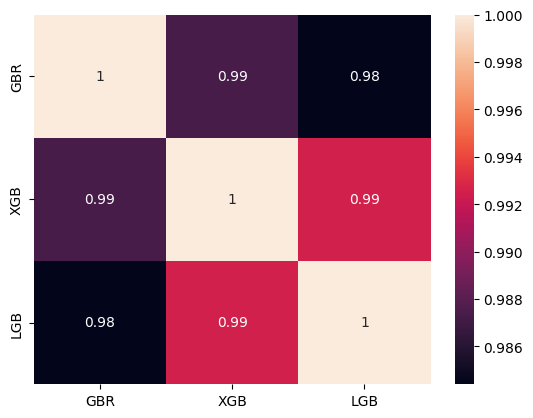

In [17]:
test_GBR = pd.Series(GBR.predict(X_test), name="GBR")
test_XGB = pd.Series(XGB.predict(X_test), name="XGB")
test_LGB = pd.Series(LGB.predict(X_test), name="LGB")

ensemble_results = pd.concat([test_GBR, test_XGB, test_LGB],axis=1)
g= sns.heatmap(ensemble_results.corr(),annot=True)

In [18]:
ensemble = np.expm1(0.1*test_GBR + 0.8*test_XGB + 0.1*test_LGB)
submission = pd.read_csv('/content/drive/My Drive/house_prices/sample_submission.csv')
submission['SalePrice'] = ensemble
submission.to_csv('./ensemble_answer.csv', index=False)

In [19]:
from sklearn.ensemble import VotingRegressor

votingC = VotingRegressor(estimators=[('GBR',GBR), ('XGB', XGB), ('LGB', LGB)], n_jobs=-1)
votingC = votingC.fit(X_train, target_label)
vote = pd.Series(votingC.predict(X_test))
submission = pd.read_csv('/content/drive/My Drive/house_prices/sample_submission.csv')
submission['SalePrice'] = vote
submission.to_csv('./vote_answer.csv', index=False)

In [20]:
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import LogisticRegression

params = {'meta_regressor__C': [0.1, 1.0, 10.0, 100.0],
          'use_features_in_secondary' : [True, False]}

clf1 = GBR
clf2 = XGB
clf3 = LGB

lr = LogisticRegression()
sr =  StackingRegressor(regressors=[clf1, clf2, clf3], meta_regressor=RandomForestRegressor())
stacking = sr.fit(X_train, target_label)
stack = stacking.predict(X_test)

submission = pd.read_csv('/content/drive/My Drive/house_prices/sample_submission.csv')
submission['SalePrice'] = stack
submission.to_csv('./stack_answer.csv', index=False)

In [21]:
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor

kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

alphas_ridge = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas_lasso = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
alphas_enect = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
enect_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

ridge = make_pipeline(RobustScaler(),
                      RidgeCV(alphas=alphas_ridge, cv=kfolds))
lasso = make_pipeline(RobustScaler(),
                      LassoCV(max_iter=10000000, alphas=alphas_lasso,
                              random_state=2, cv=kfolds))
enet = make_pipeline(RobustScaler(),
                           ElasticNetCV(max_iter=10000000, alphas=alphas_enect,
                                        cv=kfolds, l1_ratio=enect_l1ratio))
svr = make_pipeline(RobustScaler(),
                      SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

stack_gen = StackingCVRegressor(regressors=(ridge, lasso, enet,
                                            GBR, XGB, LGB),
                                meta_regressor=XGB,
                                use_features_in_secondary=True)

In [22]:
stack_gen_model = stack_gen.fit(np.array(X_train), np.array(target_label))
elastic_model = enet.fit(X_train, target_label)
lasso_model = lasso.fit(X_train, target_label)
ridge_model = ridge.fit(X_train, target_label)
svr_model = svr.fit(X_train, target_label)
gbr_model = GBR.fit(X_train, target_label)
xgb_model = XGB.fit(X_train, target_label)
lgb_model = LGB.fit(X_train, target_label)

In [23]:
def blend_models_predict(X):
    return ((0.1 * elastic_model.predict(X)) + \
            (0.1 * lasso_model.predict(X)) + \
            (0.1 * ridge_model.predict(X)) + \
            (0.1 * svr_model.predict(X)) + \
            (0.1 * gbr_model.predict(X)) + \
            (0.15 * xgb_model.predict(X)) + \
            (0.1 * lgb_model.predict(X)) + \
            (0.25 * stack_gen_model.predict(np.array(X))))

In [24]:
blend = np.floor(np.expm1(blend_models_predict(X_test)))
submission = pd.read_csv('/content/drive/My Drive/house_prices/sample_submission.csv')
submission['SalePrice'] = blend
submission.to_csv('./blend_answer.csv', index=False)